In [1]:

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Model
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn import preprocessing
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
from keras.layers import Dense, LSTM, Dropout, Embedding,Flatten,Bidirectional, MaxPooling1D,GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D,Conv1D
from keras.models import Sequential
from collections import defaultdict
from keras import regularizers
from pprint import pprint
from textwrap import wrap
import json
from keras import optimizers
output_notebook()
%matplotlib inline

Using TensorFlow backend.


Loading BokehJS ...

#### Load and prepare data

In [2]:
vocab_size= 50000
maxlen = 20
output_name_prefix = ''

In [3]:
def load_data(path_file, data_file, remove_no_path=False):
    frame = pd.read_csv(path_file)
    if remove_no_path:
        frame = frame[(frame.path != 'NOPATH')]
    #frame = frame[frame.most_frequent_percentage >= 0.6]
    data_frame = pd.read_csv(data_file)
    data_frame = data_frame[data_frame.sentence.isin(frame.sentence.values.tolist())]
    print('Paths: {} | Data: {}'.format(len(frame),len(data_frame)))
    return frame, data_frame


In [4]:
def preprocess(path_frame,reshaped=False):
    # transform labels into 3d tensors for lstm
    paths_list = path_frame['path'].values.tolist()
    tokenizer = Tokenizer(num_words=vocab_size,filters='', split=' ')
    tokenizer.fit_on_texts(paths_list)
    input_train = tokenizer.texts_to_sequences(paths_list)
    input_train = sequence.pad_sequences(input_train, maxlen=maxlen)

    # create target labels, one for each path
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(paths_list)
    y_train =  to_categorical(label_encoder.transform(paths_list))
    if reshaped:
        input_train =  input_train.reshape((len(paths_list),maxlen,1))
    pprint('Tokens {}'.format(len(tokenizer.word_counts)))
    print('{} paths total'.format(len(paths_list)))
    print('{} different (target) paths'.format(y_train[0].shape[0]))
    return input_train, y_train


#### Train the network

In [5]:
def plot_lines(history, first,second):
    plt.plot(history.history[first[0]],color=first[1])
    plt.plot(history.history[second[0]],linestyle='--',color=second[1])
    plt.title('{} vs {}'.format(first[0],second[0]))
    plt.xlabel('epoch')
    plt.legend([first[0],second[0]])
    plt.figure(figsize=(5,5))
    plt.show()
    

In [6]:
def train_model(layers,X,y,name='',epochs=100,batch_size=64, shuffle=True, validation_split=0.4, optimizer='rmsprop',
               activation_last_layer='softmax'):
    model = Sequential(name=name)
    [model.add(layer) for layer in layers]
    model.add(Dense(y[0].shape[0],activation=activation_last_layer))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    history = model.fit(X, y,
    epochs=epochs, batch_size=batch_size,shuffle=shuffle, validation_split=validation_split)
    return history, model
    

#### Prepare the embeddings

In [7]:
def get_embeddings(model,X):
    layer = list(filter(lambda x: x.name == 'embedding',model.layers))[0]
    print(layer)
    assert layer.name == 'embedding'
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=layer.output)
    return intermediate_layer_model.predict(X)

### Average Embedding

In [8]:
def average_embeddings(embeddings,path_frame,data_frame):
    assert len(path_frame) == len(embeddings)
    embedding_dict = defaultdict(list)
    mean_embedding_dict = {}
    idx = 0
    for i, row in path_frame.iterrows():
        embedding_dict[row['sentence']].append(embeddings[idx])
        idx += 1
    print(len(embedding_dict), len(data_frame))
    assert len(embedding_dict)== len(data_frame)

    for k,v in embedding_dict.items():
        adder = np.zeros(v[0].shape)
        for val in v:
            adder += val
        adder /= len(v)
        mean_embedding_dict[k] = adder

    assert len(mean_embedding_dict)== len(data_frame)
    return mean_embedding_dict

In [9]:
def reformat(mean_embedding_dict,path_frame,data_frame):
    X = []
    y = []
    plot_data = []
    plot_x = []
    idx = 0
    embedding_df = pd.DataFrame(columns=['id', 'sentence', 'label', 'embedding', 'paths'])
    for k,v in mean_embedding_dict.items():
        f_slice = path_frame[path_frame.sentence == k]
        label = f_slice.most_frequent_label.values.tolist()[0]
        f_paths = f_slice.path.values.tolist()
        embedding_df.loc[idx] = [f_slice.id.values.tolist()[0], wrap(f_slice.sentence.values.tolist()[0]),label,
                                 v.reshape(-1,1).squeeze().tolist(), [wrap(p) for p in f_paths]]
        idx+=1
        # prepare results for classification
        X.append(v.reshape(-1,1).squeeze().tolist())
        y.append(label)

        # prepare results for t-sne plot
        plot_x.append(v)
        plot_data.append( (label,k,'\n'.join(f_paths)) )
    return X, y, plot_data, plot_x, embedding_df

In [10]:
def save_embedding_df(embedding_df,name):
    embedding_df.to_csv(name+".csv")

### Plot

In [11]:
def tsne_plot(plot_x, plot_data):
    X_embedded = TSNE(n_components=2,verbose=1).fit_transform(plot_x)
    plot_frame = pd.DataFrame(columns=['x','y','class','sentence', 'path'])
    for i,x in enumerate(X_embedded):
        plot_frame.loc[i] = [x[0],x[1],plot_data[i][0],plot_data[i][1],plot_data[i][2]]

    def build_source(label, df):
        df = df[df['class'] == label]
        return ColumnDataSource(data=dict(
        x=df.x.values.tolist(),
        y=df.y.values.tolist(),
        sentence=df.sentence.tolist(),
        path=df.path.tolist(),
        label=df['class'].tolist()))

    colormap = {'WORSE': 'red', 'BETTER': 'green', 'NONE': 'blue'}
    colors = [colormap[x] for x in plot_frame['class']]

    # GROUP tooltips
    hover = HoverTool(tooltips=[
        ("Sentence", "@sentence"),
        ("Path", "@path"),
        ("label", "@label"),
    ])

    p = figure(plot_width=900,  plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,previewsave")
    p.add_tools(hover)

    p.cross(x='x', y='y', source=build_source('NONE', plot_frame),size=5,color='gray')
    p.circle(x='x', y='y', source=build_source('WORSE', plot_frame) ,size=5,color='red')
    p.circle(x='x', y='y', source=build_source('BETTER', plot_frame),size=5,color='green')
    return p

### Classification Test

In [12]:
def classification_test(X,y,data_frame,with_embeddings=False):
    _X = X
    if with_embeddings:
        print("With embeddings")
        lst_lst = np.array([json.loads(l) for l in data_frame.embedding_middle_part.values.tolist()])
        paths_ = np.asarray(X)
        infersent_ = np.array(lst_lst)
        _X = np.concatenate([paths_, infersent_],axis=1)
        assert np.asarray(X).shape[0] == paths_.shape[0] == infersent_.shape[0]
        assert _X.shape[1] == paths_.shape[1] + infersent_.shape[1]
        
    else:
        print("Without embeddings")
    
    kf = StratifiedKFold(n_splits=2, random_state=42)
    
    d = defaultdict(int)

    for train_index, test_index in kf.split(_X,y):
        X_train, X_test = np.array(_X)[train_index], np.array(_X)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
     
        log = LogisticRegression()
        log.fit(X_train, y_train)
        pred = log.predict(X_test)
        print(classification_report(y_test,pred,labels=['BETTER', 'WORSE', 'NONE']))
        print('=========\n')
        print("\n\n")

In [13]:
def full_run(layers,path_file,
             name='',reshape=False,epochs=100,batch_size=64, shuffle=True, validation_split=0.2, optimizer='rmsprop'
             ,activation_last_layer='softmax'):
    start = time.mktime(time.localtime())
    path_frame, data_frame = load_data(path_file,  '../code/data/do-not-touch/held-out-data.csv', remove_no_path=False)
    
    
    X, y = preprocess(path_frame,reshaped=reshape)
    history, trained_model = train_model(layers,X,y, name=name,epochs=epochs,batch_size=batch_size,
                                         shuffle=shuffle,activation_last_layer=activation_last_layer, validation_split=validation_split, optimizer=optimizer)

    plot_lines(history,('acc','green'),('val_acc', 'yellowgreen'))
    plot_lines(history,('loss', 'red'), ('val_loss', 'orangered'))
    embeddings = get_embeddings(trained_model,X)
    mean_embedding_dict = average_embeddings(embeddings,path_frame,data_frame)
    _X, _y, plot_data, plot_x, embedding_df = reformat(mean_embedding_dict,path_frame,data_frame)
    print('foo')
    classification_test(_X,_y,data_frame)
    #classification_test(_X,_y,data_frame,with_embeddings=True)
    save_embedding_df(embedding_df,name)
    show(tsne_plot(plot_x, plot_data))
    
    duration = (time.mktime(time.localtime()) - start) / 60
    print('Took {} minutes'.format(duration))

=========== full_paths_original_4
Paths: 1792 | Data: 1455
'Tokens 558'
1792 paths total
594 different (target) paths
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 200)           240800    
_________________________________________________________________
embedding (GlobalMaxPooling1 (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 594)               119394    
Total params: 5,360,194
Trainable params: 5,360,194
Non-trainable params: 0
_________________________________________________________________
Train on 1433 samples, validate on 359 samples
Epoch 1/150
1433/1433 [==============================] - 2s 1ms/step - loss: 4.3769 - acc: 0.5569 -

Epoch 53/150
1433/1433 [==============================] - 1s 620us/step - loss: 1.7464 - acc: 0.6560 - val_loss: 5.0710 - val_acc: 0.6546
Epoch 54/150
1433/1433 [==============================] - 1s 608us/step - loss: 1.7162 - acc: 0.6609 - val_loss: 4.9373 - val_acc: 0.6657
Epoch 55/150
1433/1433 [==============================] - 1s 602us/step - loss: 1.7033 - acc: 0.6588 - val_loss: 4.9960 - val_acc: 0.6657
Epoch 56/150
1433/1433 [==============================] - 1s 592us/step - loss: 1.6702 - acc: 0.6664 - val_loss: 4.7972 - val_acc: 0.6602
Epoch 57/150
1433/1433 [==============================] - 1s 574us/step - loss: 1.6520 - acc: 0.6643 - val_loss: 5.0587 - val_acc: 0.6602
Epoch 58/150
1433/1433 [==============================] - 1s 573us/step - loss: 1.6261 - acc: 0.6678 - val_loss: 4.8679 - val_acc: 0.6602
Epoch 59/150
1433/1433 [==============================] - 1s 616us/step - loss: 1.6135 - acc: 0.6657 - val_loss: 4.9164 - val_acc: 0.6657
Epoch 60/150
1433/1433 [==========

1433/1433 [==============================] - 1s 587us/step - loss: 0.5261 - acc: 0.9316 - val_loss: 4.8849 - val_acc: 0.6880
Epoch 113/150
1433/1433 [==============================] - 1s 593us/step - loss: 0.5055 - acc: 0.9414 - val_loss: 4.7614 - val_acc: 0.6852
Epoch 114/150
1433/1433 [==============================] - 1s 601us/step - loss: 0.4957 - acc: 0.9407 - val_loss: 4.8579 - val_acc: 0.6880
Epoch 115/150
1433/1433 [==============================] - 1s 582us/step - loss: 0.4820 - acc: 0.9435 - val_loss: 4.8735 - val_acc: 0.6852
Epoch 116/150
1433/1433 [==============================] - 1s 590us/step - loss: 0.4646 - acc: 0.9442 - val_loss: 4.8555 - val_acc: 0.6908
Epoch 117/150
1433/1433 [==============================] - 1s 608us/step - loss: 0.4630 - acc: 0.9421 - val_loss: 4.8753 - val_acc: 0.6880
Epoch 118/150
1433/1433 [==============================] - 1s 612us/step - loss: 0.4466 - acc: 0.9470 - val_loss: 4.8124 - val_acc: 0.6852
Epoch 119/150
1433/1433 [================

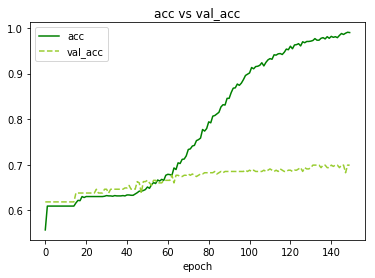

<Figure size 360x360 with 0 Axes>

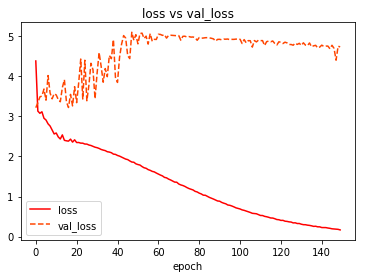

<Figure size 360x360 with 0 Axes>

1455 1455
foo
Without embeddings
             precision    recall  f1-score   support

     BETTER       0.54      0.15      0.24       138
      WORSE       0.33      0.02      0.03        60
       NONE       0.75      0.98      0.85       530

avg / total       0.68      0.74      0.67       728





             precision    recall  f1-score   support

     BETTER       0.58      0.10      0.17       138
      WORSE       0.00      0.00      0.00        59
       NONE       0.75      0.98      0.85       530

avg / total       0.66      0.73      0.65       727





[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1455 samples in 0.008s...
[t-SNE] Computed neighbors for 1455 samples in 0.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1455
[t-SNE] Computed conditional probabilities for sample 1455 / 1455
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.187668
[t-SNE] Error after 1000 iterations: 1.6627

Took 3.1666666666666665 minutes
=========== middle_paths_unrestricted_16
Paths: 2569 | Data: 1455
'Tokens 1316'
2569 paths total
1279 different (target) paths
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 200)           240800    
_________________________________________________________________
embedding (GlobalMaxPooling1 (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1279)              257079    
Total params: 5,497,879
Trainable params: 5,497,879
Non-trainable params: 0
_________________________________________________________________
Train on 2055 samples, validate on 514 samples
Epoch 1/150
2055/2055 [==============================] - 2

2055/2055 [==============================] - 1s 616us/step - loss: 2.0916 - acc: 0.5873 - val_loss: 7.6491 - val_acc: 0.4650
Epoch 53/150
2055/2055 [==============================] - 1s 611us/step - loss: 2.0371 - acc: 0.5971 - val_loss: 7.8575 - val_acc: 0.4669
Epoch 54/150
2055/2055 [==============================] - 1s 605us/step - loss: 1.9882 - acc: 0.6039 - val_loss: 7.8678 - val_acc: 0.4650
Epoch 55/150
2055/2055 [==============================] - 1s 628us/step - loss: 1.9544 - acc: 0.5990 - val_loss: 7.8394 - val_acc: 0.4767
Epoch 56/150
2055/2055 [==============================] - 1s 604us/step - loss: 1.9012 - acc: 0.6268 - val_loss: 7.7505 - val_acc: 0.4747
Epoch 57/150
2055/2055 [==============================] - 1s 611us/step - loss: 1.8556 - acc: 0.6297 - val_loss: 7.6038 - val_acc: 0.4786
Epoch 58/150
2055/2055 [==============================] - 1s 601us/step - loss: 1.8234 - acc: 0.6355 - val_loss: 7.8381 - val_acc: 0.4747
Epoch 59/150
2055/2055 [=======================

2055/2055 [==============================] - 1s 613us/step - loss: 0.4547 - acc: 0.9718 - val_loss: 7.4576 - val_acc: 0.5292
Epoch 112/150
2055/2055 [==============================] - 1s 601us/step - loss: 0.4395 - acc: 0.9708 - val_loss: 7.5666 - val_acc: 0.5292
Epoch 113/150
2055/2055 [==============================] - 1s 599us/step - loss: 0.4235 - acc: 0.9757 - val_loss: 6.8213 - val_acc: 0.5253
Epoch 114/150
2055/2055 [==============================] - 1s 601us/step - loss: 0.4132 - acc: 0.9791 - val_loss: 7.4941 - val_acc: 0.5292
Epoch 115/150
2055/2055 [==============================] - 1s 619us/step - loss: 0.3926 - acc: 0.9810 - val_loss: 7.5392 - val_acc: 0.5292
Epoch 116/150
2055/2055 [==============================] - 1s 607us/step - loss: 0.3844 - acc: 0.9786 - val_loss: 7.4766 - val_acc: 0.5292
Epoch 117/150
2055/2055 [==============================] - 1s 616us/step - loss: 0.3669 - acc: 0.9810 - val_loss: 7.4936 - val_acc: 0.5292
Epoch 118/150
2055/2055 [================

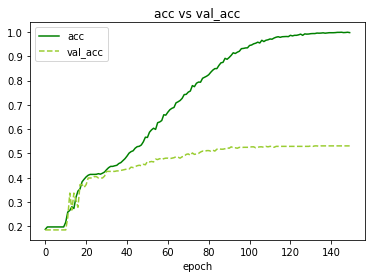

<Figure size 360x360 with 0 Axes>

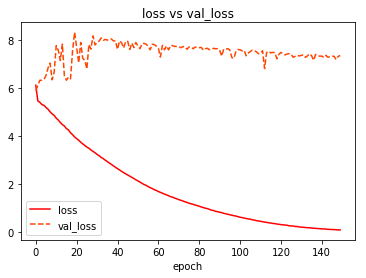

<Figure size 360x360 with 0 Axes>

1455 1455
foo
Without embeddings
             precision    recall  f1-score   support

     BETTER       0.53      0.58      0.55       138
      WORSE       0.25      0.08      0.12        60
       NONE       0.87      0.91      0.89       530

avg / total       0.75      0.78      0.76       728





             precision    recall  f1-score   support

     BETTER       0.58      0.41      0.48       138
      WORSE       0.25      0.14      0.18        59
       NONE       0.83      0.94      0.88       530

avg / total       0.74      0.77      0.75       727





[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1455 samples in 0.006s...
[t-SNE] Computed neighbors for 1455 samples in 0.451s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1455
[t-SNE] Computed conditional probabilities for sample 1455 / 1455
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.915634
[t-SNE] Error after 1000 iterations: 0.6868

Took 3.95 minutes


In [14]:
#full_orig = ['full_paths_original_4', 'full_paths_original_8', 'full_paths_original_16']
#full_unres = ['full_paths_unrestricted_4', 'full_paths_unrestricted_8','full_paths_unrestricted_16']
#middle_orig = ['middle_paths_original_4', 'middle_paths_original_8', 'middle_paths_original_16']
#middle_unres = ['middle_paths_unrestricted_4', 'middle_paths_unrestricted_8', 'middle_paths_unrestricted_16']
for x in ['full_paths_original_4','middle_paths_unrestricted_16']:

    pf = '../code/data/do-not-touch/heldout_pre_path_{}.csv'.format(x)
    name = x
    print('=========== {}'.format(name))
    lstm = 200
    full_run([
            Embedding(vocab_size,100,input_length=maxlen, input_shape=(maxlen, )),
            LSTM(lstm,return_sequences=True),
            GlobalMaxPooling1D(name='embedding'),
    ], pf,
        epochs=150,optimizer='rmsprop',batch_size=128,name=name)
